# Clustering Techniques for Animal Behavior Analysis
Part of the "QuantifyingBehavior" course

## Imports

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
import seaborn as sns
import os
from umap import UMAP

os.environ['OMP_NUM_THREADS'] = '1'

## 1. Data loading and scaling

### 1.1 Load the date and visualise the variables

In [2]:
# Generate sample data
random_state = 42
np.random.seed(random_state)

path_to_data = 'human_micrgestures.csv'
# path_to_data = 'clustering_data_sample_2.csv'
df = pd.read_csv(path_to_data)


In [3]:
df.columns

Index(['labels', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '758', '759', '760', '761', '762', '763', '764', '765', '766', '767'],
      dtype='object', length=769)

### 1.2 Scaling the data

Before applying clustering algorithms, we scale the data. This step is important because:

1. It ensures all features contribute equally to the clustering.
2. It prevents features with larger magnitudes from dominating the analysis.
3. It improves the performance and stability of many machine learning algorithms.
4. It's particularly important for distance-based algorithms like K-means.

In [4]:
# Extract the data:
X = df.drop('labels', axis=1)
y = df['labels']

In [8]:
# Standardize the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

## 2. K-means Clustering
K-means Clustering
How K-means Works

K-means is a popular and straightforward clustering algorithm used to partition data into k clusters. The algorithm works iteratively to assign each data point to one of the k clusters based on the feature similarity.
Key Concepts

    Centroids: The algorithm identifies k centroids, one for each cluster.
    Assignment: Each data point is assigned to the nearest centroid, forming k clusters.
    Update: The centroids are recalculated as the mean of all points assigned to each cluster.
    Convergence: Steps 2 and 3 are repeated until the centroids no longer change significantly.

Parameters of K-means

    k: The number of clusters to form. It is the primary parameter that needs to be set before running the algorithm.

Effects of k

    The number of clusters, k, directly determines the grouping of data points.
    Too small a k value might result in large clusters with high within-cluster variance.
    Too large a k value might lead to clusters with very few points and potentially overfitting.

Choosing Optimal k

Selecting the optimal number of clusters, k, is crucial for meaningful clustering. Here are some common methods:

    Elbow Method:
        Plot the inertia (within-cluster sum of squares) for different values of k.
        Look for the "elbow" point where the rate of decrease sharply slows. This point suggests a good balance between cluster number and tightness.

    Silhouette Analysis:
        Calculate the silhouette score for different values of k.
        The silhouette score measures how similar a point is to its own cluster compared to other clusters. A higher average silhouette score indicates better-defined clusters.

    Domain Knowledge:
        Use prior knowledge about the data to estimate a reasonable number of clusters.
        For example, if you know there are approximately k distinct groups in your data, you can set k accordingly.

Summary

K-means is a widely-used clustering algorithm that partitions data into k clusters based on feature similarity. The number of clusters, k, is a crucial parameter that can be determined using methods like the elbow method, silhouette analysis, or domain knowledge.


### 1.2. Clustering 

<AxesSubplot:xlabel='labels', ylabel='Count'>

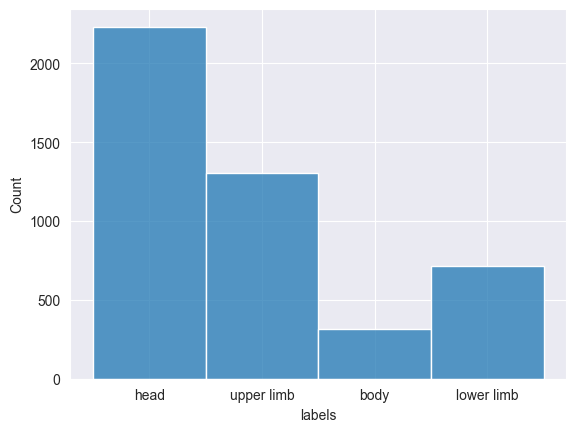

In [6]:
sns.histplot(y)

In [13]:
# Dimentionality reduction for visualization
umap_reducer = UMAP(n_components=2, min_dist=0.1, n_neighbors=300)
x_umap = umap_reducer.fit_transform(x_scaled)


In [14]:
df[['umap1','umap2']]= x_umap

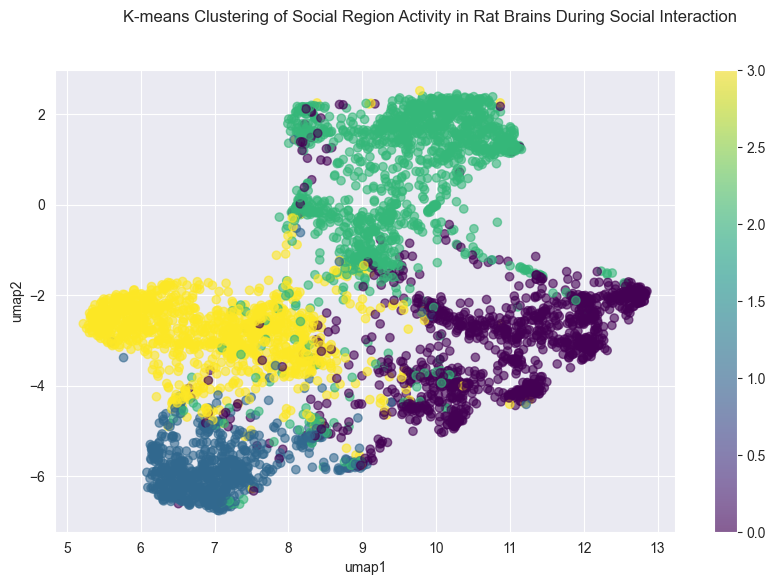

In [16]:
# Perform K-means clustering

kmeans = KMeans(n_clusters=4, random_state=random_state)
df['kmeans_cluster'] = kmeans.fit_predict(x_scaled)

# Visualize K-means results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['umap1'], df['umap2'], c=df['kmeans_cluster'], cmap='viridis', alpha=0.6)
plt.suptitle('K-means Clustering of Social Region Activity in Rat Brains During Social Interaction')
plt.xlabel('umap1')
plt.ylabel('umap2')
plt.colorbar(scatter)
plt.show()

### 2.2. Choosing the optimal number of clusters

Determining the right number of clusters is a crucial step in cluster analysis. It's especially important in animal behavior studies, where each cluster might represent a distinct behavioral state. We'll use two common methods to help us choose the optimal number of clusters:

1. **The Elbow Method**:
   - This method plots the inertia (within-cluster sum of squares) against the number of clusters.
   - As the number of clusters increases, the inertia typically decreases.
   - The "elbow" in the resulting curve suggests the optimal number of clusters.
   - After this point, adding more clusters doesn't significantly reduce inertia.

2. **Silhouette Analysis**:
   - This method measures how similar an object is to its own cluster compared to other clusters.
   - It provides a score ranging from -1 to 1 for each data point.
   - A higher average silhouette score indicates better-defined clusters.
   - We typically choose the number of clusters that maximizes the average silhouette score.

Both methods provide quantitative guidance, but it's important to balance these results with domain knowledge:

- In animal behavior studies, the biological significance of the clusters is crucial.
- Sometimes, a slightly suboptimal number of clusters from a statistical perspective might make more sense biologically.
- Always interpret the results in the context of what's known about the animal's behavior and ecology.

We'll implement both methods and compare their results to make an informed decision about the number of clusters to use in our analysis.


Helper functions

In [17]:
# Choosing the optimal number of clusters

# Function to compute inertia (within-cluster sum of squares)
def compute_inertia(k, data):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    return kmeans.inertia_

# Function to compute silhouette score
def compute_silhouette(k, data):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data)
    return silhouette_score(data, labels)

# Function to find the elbow point
def find_elbow(x, y):
    # Normalize the x and y values
    x_norm = (x - min(x)) / (max(x) - min(x))
    y_norm = (y - min(y)) / (max(y) - min(y))
    
    # Calculate the distances from each point to the line connecting the first and last points
    x_line = np.array([x_norm[0], x_norm[-1]])
    y_line = np.array([y_norm[0], y_norm[-1]])
    
    distances = []
    for i in range(len(x)):
        point = np.array([x_norm[i], y_norm[i]])
        dist = np.abs(np.cross(x_line - y_line, point - y_line)) / np.linalg.norm(x_line - y_line)
        distances.append(dist)
    
    # The elbow is the point with the maximum distance
    elbow_index = np.argmax(distances)
    return x[elbow_index]

In [18]:
# Range of k values to try
k_range = range(1, 11)

In [19]:
# Compute inertia and silhouette score for each k
inertias = [compute_inertia(k, x_scaled) for k in k_range]
silhouette_scores = [compute_silhouette(k, x_scaled) if k > 1 else 0 for k in k_range]

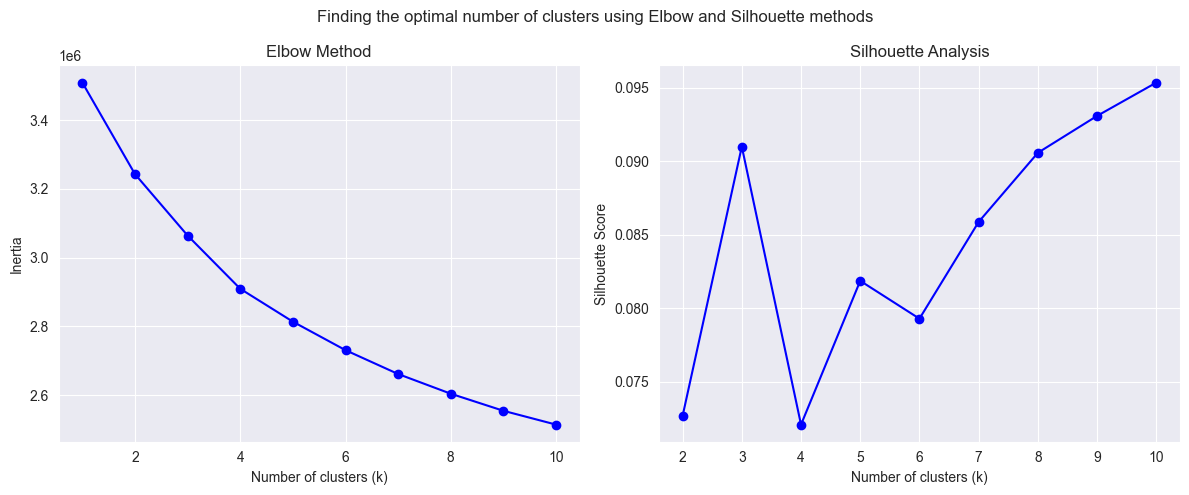

In [20]:
# Plot elbow curve
fig, axes = plt.subplots(1,2,figsize=(12, 5))
plt.suptitle('Finding the optimal number of clusters using Elbow and Silhouette methods')

axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')

# Plot silhouette scores
axes[1].plot(k_range[1:], silhouette_scores[1:], 'bo-')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')

plt.tight_layout()
plt.show()

In [21]:
# Print the optimal k based on silhouette score
optimal_k_silhouette = silhouette_scores.index(max(silhouette_scores[1:])) + 1
print(f"The optimal number of clusters based on silhouette analysis is: {optimal_k_silhouette}")

# Find the optimal k
optimal_k_elbow = find_elbow(np.array(k_range), np.array(inertias))
print(f"The optimal number of clusters based on elbow method analysis is: {optimal_k_elbow}")

The optimal number of clusters based on silhouette analysis is: 10
The optimal number of clusters based on elbow method analysis is: 4


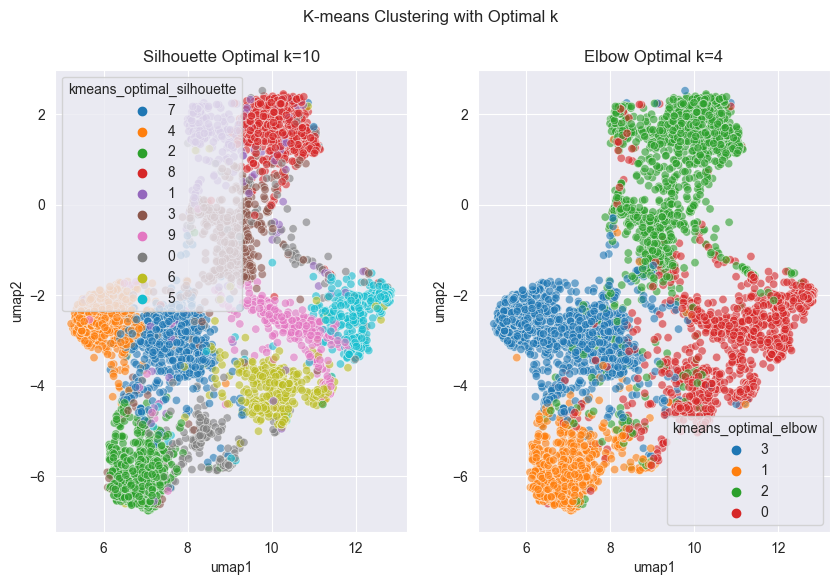

In [24]:
# Visualize clustering with optimal k
kmeans_optimal_silhouette = KMeans(n_clusters=optimal_k_silhouette, random_state=random_state)
kmeans_optimal_elbow = KMeans(n_clusters=optimal_k_elbow, random_state=random_state)
df['kmeans_optimal_silhouette'] = kmeans_optimal_silhouette.fit_predict(x_scaled).astype(str)
df['kmeans_optimal_elbow'] = kmeans_optimal_elbow.fit_predict(x_scaled).astype(str)

fig, axes = plt.subplots(1, 2, figsize=(10,6))
fig.suptitle('K-means Clustering with Optimal k')
sns.scatterplot(data=df, x='umap1', y='umap2', hue='kmeans_optimal_silhouette', alpha=0.6, ax=axes[0])
axes[0].set_title(f'Silhouette Optimal k={optimal_k_silhouette}')


sns.scatterplot(data=df, x='umap1', y='umap2', hue='kmeans_optimal_elbow', alpha=0.6, ax=axes[1])
axes[1].set_title(f'Elbow Optimal k={optimal_k_elbow}')

plt.show()

# Analysis and Interpretation of Cluster Selection

1. **The Elbow Method:**
   - Plots the inertia (within-cluster sum of squares) against the number of clusters.
   - The 'elbow' in the curve suggests the optimal number of clusters.
   - After this point, adding more clusters doesn't significantly reduce inertia.

2. **Silhouette Analysis:**
   - Measures how similar an object is to its own cluster compared to other clusters.
   - Higher silhouette scores indicate better-defined clusters.
   - The peak in the silhouette score suggests the optimal number of clusters.

3. **Optimal Number of Clusters:**
   - In this case, the optimal number of clusters is 2 with the Silhouette method in 3 with the Elbow method.

4. **Implications for Animal Behavior Analysis:**
   - The optimal k might reveal more or fewer distinct behavioral states than expected.
   - Consider domain knowledge when deciding on the final number of clusters to use.


## 3. DBSCAN: Density-Based Spatial Clustering of Applications with Noise
**How DBSCAN Works**

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a popular clustering algorithm known for its ability to identify clusters of varying shapes and sizes in a dataset, along with the ability to mark outliers as noise. The algorithm groups together points that are closely packed and marks as outliers points that lie alone in low-density regions.

**Key Concepts**

    Core Point: A point is a core point if it has at least min_samples points (including itself) within a distance eps.
    Border Point: A point is a border point if it is not a core point but lies within the eps radius of a core point.
    Noise Point: A point is a noise point if it is neither a core point nor a border point.

**Parameters of DBSCAN**

    eps (ε): The maximum distance between two points for them to be considered as neighbors. It defines the radius of a neighborhood around a point.
    min_samples: The minimum number of points required to form a dense region (including the core point itself). It defines the minimum number of neighbors within eps radius for a point to be considered a core point.

**Effects of eps and min_samples**

    eps:
        A smaller eps value will create smaller clusters and can lead to many points being classified as noise.
        A larger eps value will result in larger clusters and fewer noise points, potentially merging distinct clusters.

    min_samples:
        A smaller min_samples value may lead to many small clusters and less noise.
        A larger min_samples value requires more points to form a dense region, resulting in larger and fewer clusters with potentially more noise.

**Choosing Optimal Parameters**

Selecting the optimal values for eps and min_samples is crucial for effective clustering with DBSCAN. Here are some common approaches:

    K-Nearest Neighbors (K-NN) Plot:
        Plot the distances of each point to its k-th nearest neighbor (where k is min_samples).
        Look for the "knee" point in the plot, which is a sudden change in distance. This value can be a good choice for eps.

    Domain Knowledge:
        Use prior knowledge about the data to set reasonable values for eps and min_samples.
        For example, if you know the typical density or distance between points in your dataset, you can set eps accordingly.

    Experimentation:
        Experiment with different values of eps and min_samples to see how the clustering results change.
        Evaluate the clustering results using metrics like the silhouette score to find the best parameters.

**Summary**

DBSCAN is a powerful clustering algorithm, especially suited for identifying clusters in datasets with noise and varying densities. The choice of eps and min_samples significantly impacts the clustering outcome. Using techniques like K-NN plots, domain knowledge, and experimentation can help in selecting the optimal parameters for effective clustering.

In [53]:
from sklearn.preprocessing  import MinMaxScaler
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)


In [55]:
x_scaled

array([[-0.10565674, -0.86992466,  1.69673759, ..., -0.65106515,
         0.41651425,  0.11523269],
       [ 0.98218395, -1.41529544, -0.4319666 , ..., -0.27014344,
         0.79494231,  0.55783112],
       [ 0.17439065, -1.78793454,  0.60787222, ...,  0.40569747,
        -0.03550031, -0.13705471],
       ...,
       [-0.61428465, -0.52665306, -0.26013348, ...,  1.89201474,
        -0.65979892,  0.0121339 ],
       [-0.36502966, -1.78010552,  0.08677931, ..., -1.48397444,
         1.39087696,  0.22344072],
       [-0.8918605 , -2.30021079, -0.7829614 , ..., -1.24694129,
        -0.4145898 , -0.72530131]])

In [57]:
df['dbscan_05_5']

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
4564    -1
4565    -1
4566    -1
4567    -1
4568    -1
Name: dbscan_05_5, Length: 4569, dtype: object

In [62]:
# Clustering with different parameters
dbscan_05_5 = DBSCAN(eps=0.01, min_samples=5)
df['dbscan_05_5'] = dbscan_05_5.fit_predict(X_norm).astype(str)

dbscan_05_5 = DBSCAN(eps=10, min_samples=200)
df['dbscan_5_15'] = dbscan_05_5.fit_predict(X_norm).astype(str)

dbscan_05_5 = DBSCAN(eps=0.05, min_samples=2)
df['dbscan_01_2'] = dbscan_05_5.fit_predict(X_norm).astype(str)

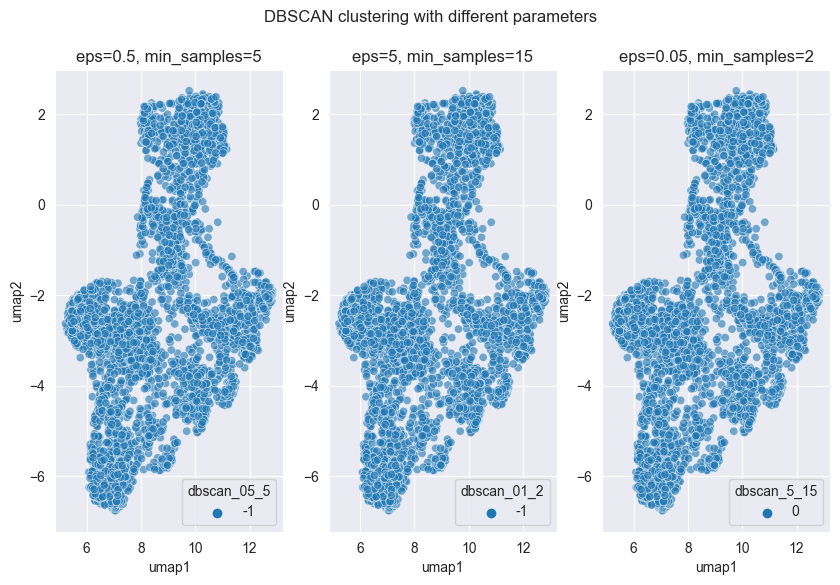

In [63]:
# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(10,6))
plt.suptitle('DBSCAN clustering with different parameters')

sns.scatterplot(data=df, x='umap1', y='umap2', hue='dbscan_01_2', alpha=0.6, ax=axes[1])
axes[0].set_title('eps=0.5, min_samples=5')

sns.scatterplot(data=df, x='umap1', y='umap2', hue='dbscan_05_5', alpha=0.6, ax=axes[0])
axes[1].set_title('eps=5, min_samples=15')

sns.scatterplot(data=df, x='umap1', y='umap2', hue='dbscan_5_15', alpha=0.6, ax=axes[2])
axes[2].set_title('eps=0.05, min_samples=2')

plt.show()

## 3.Hierarchical Clustering
**How Hierarchical Clustering Works**

Hierarchical clustering is a method of cluster analysis which seeks to build a hierarchy of clusters. It can be either agglomerative (bottom-up) or divisive (top-down). The most common type is agglomerative clustering.
Key Concepts

    Agglomerative Clustering:
        Start with each data point as its own cluster.
        Iteratively merge the closest pairs of clusters until only a single cluster remains or the desired number of clusters is reached.

    Divisive Clustering:
        Start with all data points in a single cluster.
        Iteratively split the cluster into smaller clusters until each data point is in its own cluster or the desired number of clusters is reached.

    Linkage Criteria:
        Single Linkage: Distance between the closest points of the clusters.
        Complete Linkage: Distance between the farthest points of the clusters.
        Average Linkage: Average distance between all points of the clusters.
        Ward’s Method: Minimize the variance within each cluster.

**Parameters of Hierarchical Clustering**

    n_clusters: The number of clusters to form.
    Linkage: The criteria used to merge clusters (single, complete, average, or Ward).

**Effects of n_clusters and Linkage**

    n_clusters:
        Determines the final number of clusters.
        A smaller number of clusters will result in broader, more inclusive clusters.
        A larger number of clusters will result in more specific, tighter clusters.

    Linkage:
        Determines how the distance between clusters is measured.
        Single linkage can result in elongated, "chained" clusters.
        Complete linkage tends to produce more compact clusters.
        Average linkage provides a balance between single and complete linkage.
        Ward’s method aims to minimize the variance within each cluster.

**Choosing Optimal Parameters**

Selecting the optimal parameters for hierarchical clustering can be achieved using the following methods:

    Dendrogram Analysis:
        Plot a dendrogram to visualize the hierarchical structure of the data.
        Identify a suitable number of clusters by looking for the longest vertical line in the dendrogram that does not intersect any clusters.

    Silhouette Analysis:
        Calculate the silhouette score for different numbers of clusters.
        Choose the number of clusters that maximizes the silhouette score.

    Domain Knowledge:
        Use prior knowledge about the data to inform the choice of the number of clusters and linkage method.

**Summary**

Hierarchical clustering builds a hierarchy of clusters using either agglomerative or divisive approaches. The number of clusters (n_clusters) and linkage criteria are key parameters that affect the clustering outcome. Dendrogram analysis, silhouette analysis, and domain knowledge can help in choosing optimal parameters for effective clustering.

In [64]:
# Create dendrogram
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

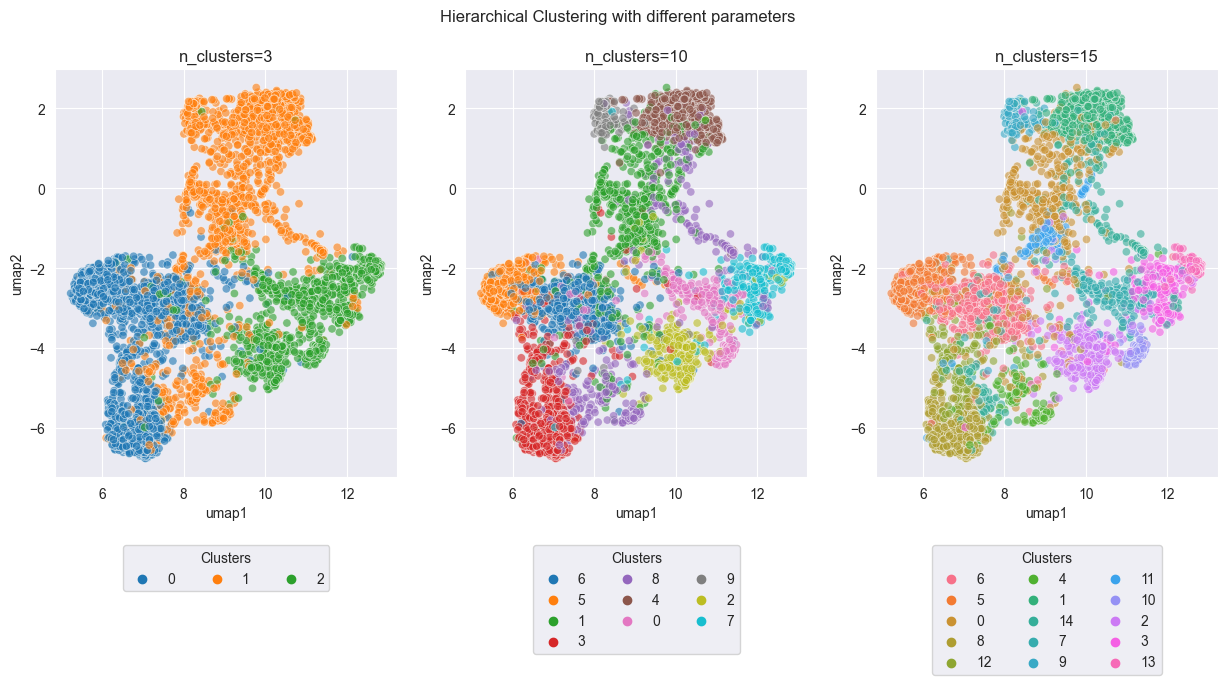

In [66]:
# Clustering with different parameters
hierarchical_3 = AgglomerativeClustering(n_clusters=3)
df['hierarchical_cluster_3'] = hierarchical_3.fit_predict(x_scaled).astype(str)

hierarchical_10 = AgglomerativeClustering(n_clusters=10)
df['hierarchical_cluster_10'] = hierarchical_10.fit_predict(x_scaled).astype(str)

hierarchical_15 = AgglomerativeClustering(n_clusters=15)
df['hierarchical_cluster_15'] = hierarchical_15.fit_predict(x_scaled).astype(str)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
plt.suptitle('Hierarchical Clustering with different parameters')

# Subplot 1
sns.scatterplot(data=df, x='umap1', y='umap2', hue='hierarchical_cluster_3', alpha=0.6, ax=axes[0])
axes[0].set_title('n_clusters=3')
legend = axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
legend.set_title('Clusters')

# Subplot 2
sns.scatterplot(data=df, x='umap1', y='umap2', hue='hierarchical_cluster_10', alpha=0.6, ax=axes[1])
axes[1].set_title('n_clusters=10')
legend = axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
legend.set_title('Clusters')

# Subplot 3
sns.scatterplot(data=df, x='umap1', y='umap2', hue='hierarchical_cluster_15', alpha=0.6, ax=axes[2])
axes[2].set_title('n_clusters=15')
legend = axes[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
legend.set_title('Clusters')

# Adjusting the layout to make room for the legends
plt.subplots_adjust(bottom=0.2)

plt.show()

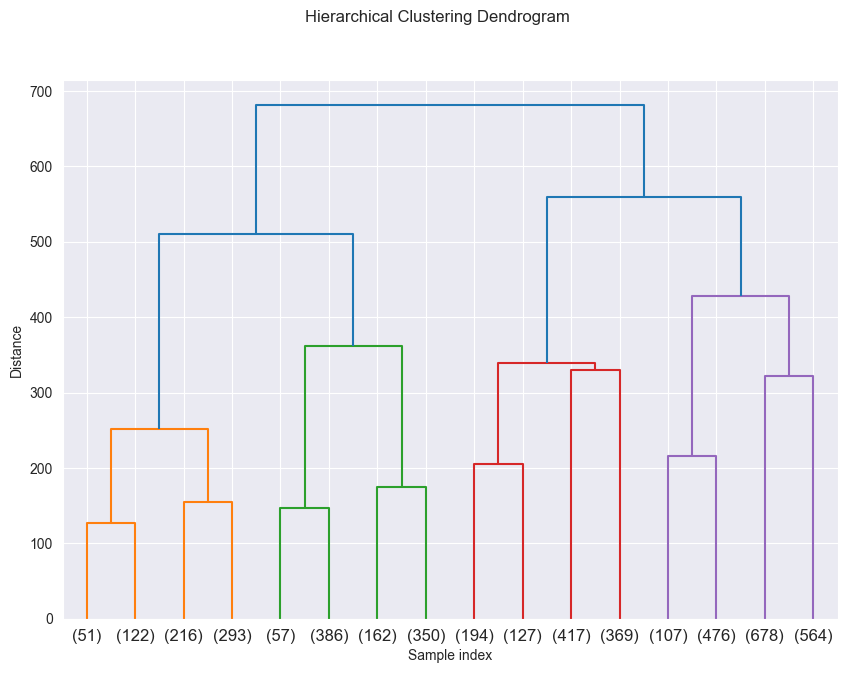

In [67]:
hierarchical_dendro = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hierarchical_dendro = hierarchical_dendro.fit(x_scaled)

plt.figure(figsize=(10, 7))
plot_dendrogram(hierarchical_dendro, truncate_mode='level', p=3)
plt.suptitle('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [21]:
`# 1. Drop kmeans_cluster
df.drop(columns=['kmeans_cluster'], inplace=True)

# 2. Melt the DataFrame to have a long format suitable for plotting
df_melted = df.melt(id_vars=['sociability', 'var1', 'var2'], var_name='clustering_method', value_name='cluster')

# Extract method and parameters
df_melted['method'] = df_melted['clustering_method'].apply(lambda x: x.split('_')[0])
df_melted['parameters'] = df_melted['clustering_method'].apply(lambda x: '_'.join(x.split('_')[1:]))


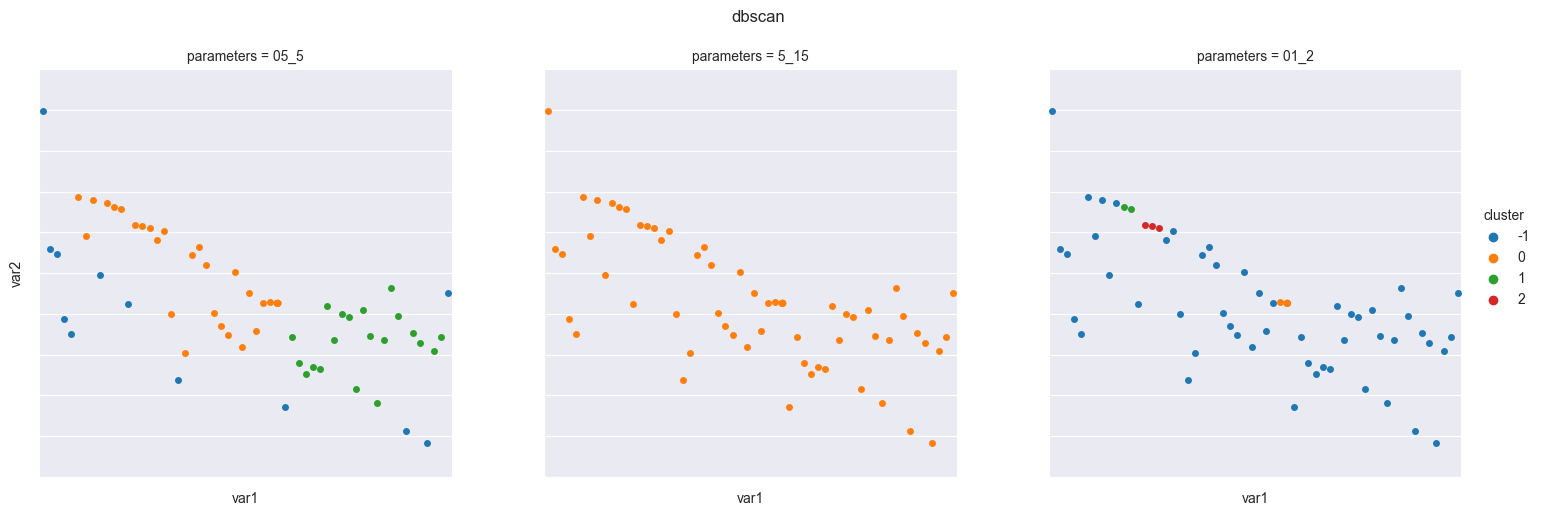

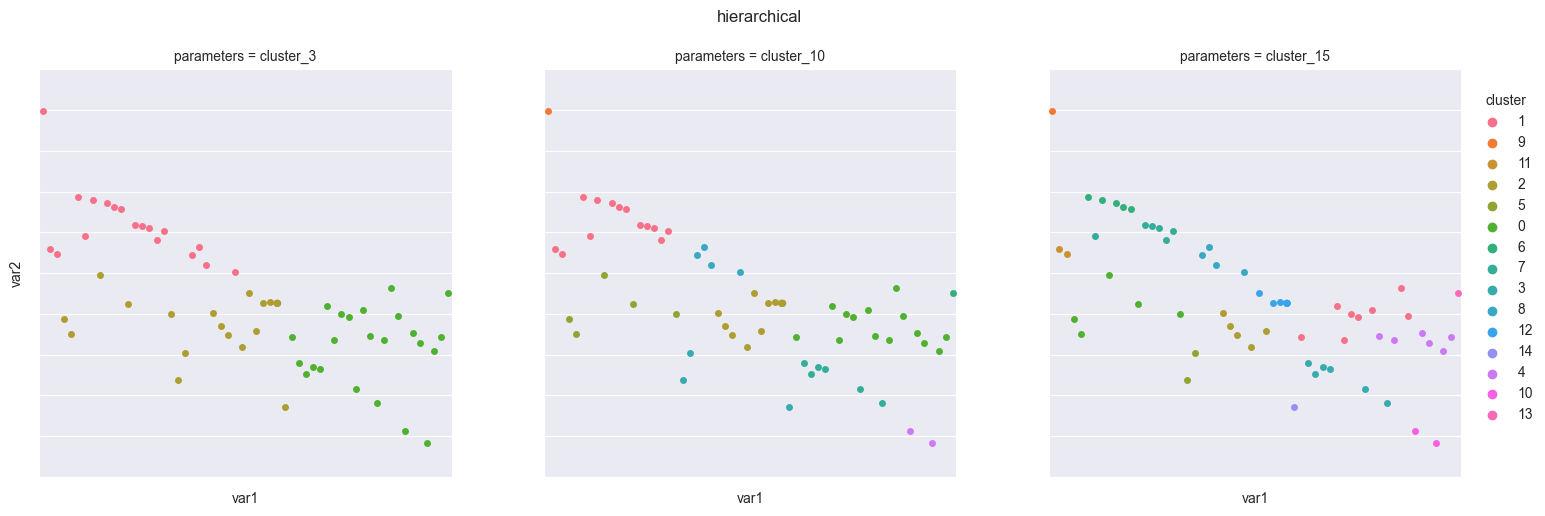

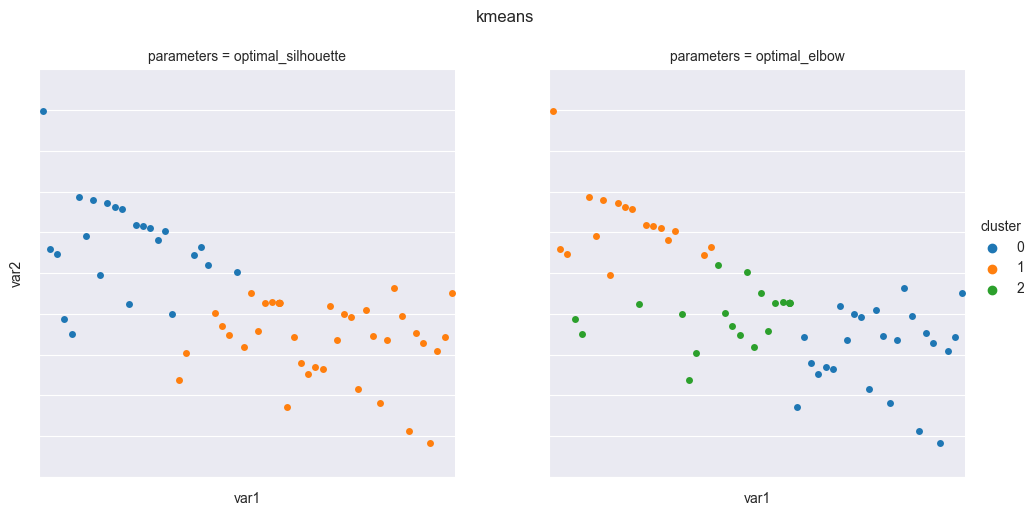

In [60]:
df_melted_g = df_melted.groupby(['method'])
for method, df_e in df_melted_g:
    g = sns.catplot(data=df_e, x='var1', y='var2', hue='cluster', col='parameters', legend=True)
    g.set_xticklabels('', '')  # Remove axis labels
    g.set_yticklabels('')  # Remove axis labels
    plt.suptitle(method, y=1.05)
    plt.show()
    

# Analysis and Interpretation

1. **K-means and Hierarchical clustering identified three main clusters in the animal movement data.**
2. **The clusters likely represent different behavioral states or habitats.**
3. **K-means provides centroids that could represent average positions for each behavior.**
4. **Hierarchical clustering allows for exploration of sub-clusters within main clusters.**
5. **DBSCAN identified clusters based on density and may find noise points (labeled as -1).**
6. **The dendrogram visualizes the hierarchy of clusters, which can be useful for understanding relationships between behaviors.**


